In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_style('white')
np.random.seed(42)

from scipy.stats import ttest_rel
from scipy.stats import combine_pvalues

from gpu_utils import restrict_GPU_pytorch
from fig_helpers import add_metrics_to_df, adjust_box_widths
from paths import FIG_DIR
restrict_GPU_pytorch('0')

val_loss_key = 'auc'

orig = sns.color_palette('colorblind')
method_colors = [orig[2], orig[0], orig[1], orig[3], orig[4]]
method_colors = ['#4daf4a', '#e41a1c', '#377eb8', '#ff7f00', '#984ea3']
hue_order = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
plotted_methods = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
method_name_dict = {"supervised": "Supervised", "negative": "Negative", "scar-c": "SCAR-C",
                    'scar-km2': 'KM2', "sar-em": "EM", "ours": "PURPLE"}

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Using GPU:0


# Figure 2a: Illustration of PU Learning settings.

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8, 4))

# Traditional PU learning setup
n_examples = 750
neg = np.random.multivariate_normal((0, 0), [[.2, 0], [0, .25]], n_examples)
pos = np.random.multivariate_normal((2, 2), [[.25, .05], [.05, .25]], n_examples)

neg = np.concatenate([neg, np.zeros((n_examples, 1))], axis=1)
pos = np.concatenate([pos, np.ones((n_examples, 1))], axis=1)
neg_df = pd.DataFrame(neg, columns=['feat1', 'feat2', 'label'])
pos_df = pd.DataFrame(pos, columns=['feat1', 'feat2', 'label'])
feats_df = pd.concat([neg_df, pos_df], ignore_index=True)
sns.kdeplot(data=feats_df, x='feat1', y='feat2', hue='label', fill=True,
            ax=axs[0], legend=True, palette=[red_color, green_color], alpha=.75)

red_patch = mpatches.Patch(color=red_color, label='Negative')
green_patch = mpatches.Patch(color=green_color, label='Positive')
axs[0].legend(handles = [red_patch, green_patch], labels = ['Negative','Positive'],loc = 'upper left')

axs[0].axes.xaxis.set_ticks([])
axs[0].axes.yaxis.set_ticks([])
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
axs[0].set_title('(1) Separable', fontsize=BIGGER_SIZE)

# # our case

neg = np.random.multivariate_normal((.52, .52), [[.75, .25], [.3, .75]], n_examples)
pos = np.random.multivariate_normal((1, 1), [[.25, .05], [.05, .2]], n_examples)
neg = np.concatenate([neg, np.zeros((n_examples, 1))], axis=1)
pos = np.concatenate([pos, np.ones((n_examples, 1))], axis=1)

neg_df = pd.DataFrame(neg, columns=['feat1', 'feat2', 'label'])
pos_df = pd.DataFrame(pos, columns=['feat1', 'feat2', 'label'])
feats_df = pd.concat([neg_df, pos_df], ignore_index=True)
sns.kdeplot(data=feats_df, x='feat1', y='feat2', hue='label', fill=True, alpha=.75, 
                palette = [red_color, green_color], ax=axs[1], legend=True)
axs[1].legend().set_visible(False)

axs[1].axes.xaxis.set_ticks([])
axs[1].axes.yaxis.set_ticks([])
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('')
axs[1].set_title('(2) Nonseparable', fontsize=BIGGER_SIZE)

plt.tight_layout()
plt.savefig(FIG_DIR + 'synthetic_intro.pdf', format='pdf', dpi=600)

# Figure 2b: Performance over Separability Conditions.

In [ ]:
group_gap_results_df = pd.concat([pd.read_csv('results/group_gap_supervised_results'),
                            pd.read_csv('results/group_gap_ours_results'),
                            pd.read_csv('results/group_gap_scar-km2_results'),
                            pd.read_csv('results/group_gap_sar-em_results'),
                            pd.read_csv('results/group_gap_negative_results')])
label_freq_results_df = pd.concat([pd.read_csv('results/label_freq_scar-km2_results'),
                            pd.read_csv('results/label_freq_ours_results'),
                            pd.read_csv('results/label_freq_supervised_results'),
                            pd.read_csv('results/label_freq_sar-em_results'),
                            pd.read_csv('results/label_freq_negative_results')])
separability_results_df = pd.concat([pd.read_csv('results/separability_scar-km2_results'),
                            pd.read_csv('results/separability_ours_results'),
                            pd.read_csv('results/separability_cdmm_results'),
                            pd.read_csv('results/separability_supervised_results'),
                            pd.read_csv('results/separability_sar-em_results'),
                            pd.read_csv('results/separability_negative_results')])

group_gap_results_df = add_metrics_to_df(group_gap_results_df)
label_freq_results_df = add_metrics_to_df(label_freq_results_df)
separability_results_df = add_metrics_to_df(separability_results_df)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
modes = ['separable', 'overlap']
for i, mode in enumerate(modes):
    our_results = separability_results_df[separability_results_df['method'] == 'ours']
    other_results = separability_results_df[separability_results_df['method'] != 'ours']
    our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run', 'separability_assumption']).head(1)
    expmt_results = pd.concat([our_results, other_results])
    expmt_results = expmt_results[expmt_results['separability_assumption'] == mode]
    
    g = sns.boxplot(x='method', y='rel_prior_err_pct', 
                     data=expmt_results, 
                     order=hue_order, ax=axs[i], zorder=2)
    
    g.set_yscale('log', base=2)
    axs[i].set_xlabel("Separability")
    axs[i].axhline(y=1.0, color='black', linestyle='--', zorder=1,
                   linewidth=1)
    if i == 0:
        axs[i].set_ylabel("Ratio of Predicted Relative Prior \n to True Relative Prior")
    else:
        axs[i].set_ylabel("")
    
    # Change the color of the entire box to be method color
    for j,box in enumerate(axs[i].artists):
        color = method_colors[j]
        box.set_edgecolor(color)
        box.set_facecolor('white')
        for k in range(6*j,6*(j+1)):
             axs[i].lines[k].set_color(color)
                
    axs[i].set_ylim([.45, 2.0])
    axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])

axs[0].set_title("(1) Separable")
axs[1].set_title("(2) Nonseparable")
# Make legend
patches = []
for method_name, method_color in zip(hue_order, method_colors):
    patches.append(mpatches.Patch(color=method_color, label=method_name))
labels = [method_name_dict[m] for m in hue_order]
axs[1].legend(handles = patches, labels = labels,loc = 'lower right')

    
plt.tight_layout()
plt.savefig(FIG_DIR + 'synthetic_separability.pdf', dpi=300)  


# Figure  2c: Robustness to Covariate Shift.

In [ ]:
plt.figure(figsize=(8,4))

group_gap_results_df = group_gap_results_df[group_gap_results_df['method'].isin(plotted_methods)]

# Select performance our method based on val_loss_key
our_results = group_gap_results_df[group_gap_results_df['method'] == 'ours']
other_results = group_gap_results_df[group_gap_results_df['method'] != 'ours']
our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['group_gap', 'run']).head(1)
group_gap_results_df = pd.concat([our_results, other_results])
group_gap_results_df['abs_group_gap'] = np.abs(group_gap_results_df['group_gap'])

g = sns.pointplot(x='abs_group_gap', y='rel_prior_err_pct', hue='method', data=group_gap_results_df, 
            hue_order = plotted_methods, scale=.75, 
            linestyles=['-', '-', '-', '-', '-'], palette=method_colors)
plt.xlabel("Gap between p(x | g = 1) and p(x | g = 2)")

g.set_yscale('log', base=2)
g.set_ylim(.45, 2.0)
g.set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])

# alpha=.5
# plt.setp(g.collections[:-1], alpha=alpha) #for the markers
# plt.setp(g.lines[:-6], alpha=alpha)

linewidth=4
plt.setp(g.collections[-1], linewidth=linewidth) #for the markers
plt.setp(g.lines[-6:], linewidth=linewidth)
# g.set_yticklabels([])
plt.ylabel("")

g.set_ylabel("Predicted Relative Prior")

plt.axhline(y=1.0, color='black', linestyle='--', zorder=1,
            linewidth=1)
# g.get_legend().remove()

patches = []
for method_name, method_color in zip(hue_order, method_colors):
    patches.append(mpatches.Patch(color=method_color, label=method_name))
labels = [method_name_dict[m] for m in hue_order]
ax = plt.gca()
ax.legend(handles = patches, labels = labels,loc = 'lower left')

plt.tight_layout()
plt.savefig(FIG_DIR + 'synthetic_covariate_shift.pdf', dpi=300)  


# Figure 2d: Robustness to Violations of Covariate Shift.

In [ ]:
results_df = pd.concat([pd.read_csv('./results/robustness_ours_underestimate_results'),
                        pd.read_csv('./results/robustness_supervised_underestimate_results'),
                        pd.read_csv('./results/robustness_sar-em_underestimate_results'),
                        pd.read_csv('./results/robustness_scar-km2_underestimate_results'),
                        pd.read_csv('./results/robustness_negative_underestimate_results')],
                       ignore_index=True)
results_df = pd.read_csv('./results/robustness_ours_underestimate_results')
results_df = add_metrics_to_df(results_df)

# g2_mean is stored as vector - g1 mean = 1, so we add a column 
# corresponding to the g2 mean
results_df['g2_mean_scalar'] = 1 + results_df['group_gap']
set(results_df['g2_mean_scalar'])

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
group_gap_results  = results_df
colors = ['#f2f0f7', '#cbc9e2', '#9e9ac8', '#756bb1', '#54278f']
plt.figure(figsize=(8,4))
g = sns.lineplot(x='p_y_diff', y='rel_prior_err_pct', hue='g2_mean_scalar',
             marker='o',
             hue_order=[1, .75, .5, 0, -1.0],
             palette=colors,
             data=group_gap_results)
plt.xlabel("Difference in p(y|x,g) between groups \np( y = 1 | x, g = a) - p( y = 1 | x, g = b)")
plt.ylabel("Ratio of Predicted Relative Prevalence \n to True Relative Prevalence")

g.set_ylim([.5, 1.1])
g.set_yticks([.6, .8, 1.0])
g.set_yticklabels(["0.6x", "0.8x",  "1.0x"])

g.axhline(y=1.0, color='black', linestyle='--', zorder=1,
                   linewidth=1)
g.get_legend().set_title('$E[x|g=b]$')

plt.tight_layout()
plt.savefig(FIG_DIR + 'synthetic_robustness.pdf', format='pdf', dpi=600)

# Statistical Comparisons

In [ ]:
# Across separability assumptions
sep_assumption = 'overlap'
for sep_assumption in ['separable', 'overlap']:
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        print("Separability Assumption: ", sep_assumption, "Method: ", method)
        expmt_results = separability_results_df[separability_results_df['separability_assumption'] == sep_assumption]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        print(ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct']))
        print()

In [ ]:
# Across label frequencies
max_pvals = []
for label_freq in [.1, .3, .5, .7, .9]:
    pvals = []
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        expmt_results = label_freq_results_df[label_freq_results_df['labeling_frequency_g2'] == label_freq]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        x, pval = ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct'])
        pvals.append(pval)
        print("Label Frequency: ", label_freq, "Method: ", method, 'p-val: ', pval)
    max_pvals.append(np.max(pvals))
print(combine_pvalues(max_pvals))
# Across covariate shifts

In [ ]:
# Across label frequencies
max_pvals = []
for group_gap in list(set(group_gap_results_df['group_gap'])):
    pvals = []
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        expmt_results = group_gap_results_df[group_gap_results_df['group_gap'] == group_gap]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        x, pval = ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct'])
        pvals.append(pval)
        print("Group gap: ", group_gap, "Method: ", method, 'p-val: ', pval)
    max_pvals.append(np.max(pvals))
print(combine_pvalues(max_pvals))
# Across covariate shifts

# Train a baseline  on simulated data

In [1]:
import torch

from sarpu.pu_learning import *
from eval_fs import eval_relative_prior
from method import train_relative_estimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from simulation_helpers import create_gap_1d, create_gap_nd
from simulation_helpers import generate_g, generate_y, generate_s_scar
from simulation_helpers import separable_decision_rule_1d, inseparable_decision_rule_1d
from simulation_helpers import separable_decision_rule_nd, inseparable_decision_rule_nd

from method import train_relative_estimator, get_loss
from baselines import cdmm, supervised_rel_prior, sar_em_rel_prior, scar_km2_rel_prior

### Generating data for each group.

Parameters that you can plan with are $c_1$, $c_2$, group_gap, and separability assumption ('separable', 'overlap', 'overlaid'). In addition, you can change std, the standard deviation of the Gaussian distributions for each group, n_to_sample, and n_attributes.

In [2]:
# Parameter settings
c1 = .5
c2 = .3
n_groups = 2
group_gap = -2
scar_assumption = True
separability_assumption = 'overlap'
std, n_to_sample, n_attributes = 16, 10000, 5
n_epochs = 10000

n_to_sample_g1 = n_to_sample
n_to_sample_g2 = 2*n_to_sample

g1_mean = np.ones(n_attributes)
g2_mean =  g1_mean + group_gap
g1_config = {'mean': g1_mean, 'std': std, 'n_samples': n_to_sample_g1, 
             'n_attributes': n_attributes, 'n_groups': n_groups, 'group_feat': 1, 'n_epochs':n_epochs,
                 'group1_idx': 0}
g1_config['lamda'] = 0
g2_config = {'mean': g2_mean, 'std': std, 'n_samples': n_to_sample_g2, 
             'n_attributes': n_attributes, 'n_groups': n_groups, 'group_feat': 2, 
             'group1_idx': 0}

expmt_config = {'scar_assumption': scar_assumption, 
                'separability_assumption': separability_assumption, 
                'labeling_frequency_g1': c1, 'labeling_frequency_g2': c2, 
                 'group1_idx': 0} 

In [3]:
x1 = generate_g(g1_config)
x2 = generate_g(g2_config)

if expmt_config['separability_assumption'] == 'separable':
    y1 = generate_y(x1, g1_config, separable_decision_rule_nd)
    y2 = generate_y(x2, g2_config, separable_decision_rule_nd)
    x1, y1 = create_gap_nd(x1, y1, g1_config)
    x2, y2 = create_gap_nd(x2, y2, g2_config)
elif expmt_config['separability_assumption'] == 'overlap':
    y1 = generate_y(x1, g1_config, inseparable_decision_rule_nd, beta=1)
    y2 = generate_y(x2, g2_config, inseparable_decision_rule_nd, beta=1)
elif expmt_config['separability_assumption'] == 'overlaid':
    beta = 1
    y1 = generate_y(x1, g1_config, inseparable_decision_rule_nd, beta=.75, scale=.75)
    y2 = generate_y(x2, g2_config, inseparable_decision_rule_nd, beta=.75, scale=.75)

# generate observed labels
if expmt_config['scar_assumption']:
    s1 = generate_s_scar(y1, expmt_config['labeling_frequency_g1'])
    s2 = generate_s_scar(y2, expmt_config['labeling_frequency_g2'])


# split into train, val, test
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
s = np.concatenate([s1, s2])

### Splitting  x, y, and s into train and test sets.

We assume that the data is stratified by group across the train and test set. That is, p(g=1) is constant across each split.

In [4]:
x1_train, x1_test, y1_train, y1_test, s1_train, s1_test = train_test_split(x1, y1, s1, test_size=.2, 
                                                                                  random_state=10, shuffle=True, stratify=y1)
x2_train, x2_test, y2_train, y2_test, s2_train, s2_test = train_test_split(x2, y2, s2, test_size=.2, 
                                                                                  random_state=10, shuffle=True, stratify=y2)

x_train = np.concatenate([x1_train, x2_train])
y_train = np.concatenate([y1_train, y2_train])
s_train = np.concatenate([s1_train, s2_train])

x_test = np.concatenate([x1_test, x2_test])
y_test = np.concatenate([y1_test, y2_test])
s_test = np.concatenate([s1_test, s2_test])

scale_factor = np.max(np.abs(x_train))
x_train_norm = x_train/scale_factor
x_test_norm = x_test/scale_factor

g1_train_idxs = x_train[:,0] == 1
g2_train_idxs = x_train[:,1] == 1
g1_test_idxs = x_test[:,0] == 1
g2_test_idxs = x_test[:,1] == 1
classification_attributes = [i + n_groups for i in range(n_attributes)]

### Quick summary of the group statistics:

In [5]:
print("--- Group-specific p(y=1) --- ")
print("p( y = 1 | g = 1 )", np.mean(y1))
print("p( y = 1 | g = 2 )", np.mean(y2))

print("--- Group-specific p(s=1) --- ")
print("p( s = 1 | g = 1 )", np.mean(s1))
print("p( s = 1 | g = 2 )", np.mean(s2))

print("--- Number of Samples ---")
print(len(x))

--- Group-specific p(y=1) --- 
p( y = 1 | g = 1 ) 0.6576
p( y = 1 | g = 2 ) 0.34605
--- Group-specific p(s=1) --- 
p( s = 1 | g = 1 ) 0.3288
p( s = 1 | g = 2 ) 0.1038
--- Number of Samples ---
30000


# Train a baseline

In [6]:
# Change method here to play with a different baseline
method = 'supervised'
if method == 'supervised':
    results = supervised_rel_prior(x_train[g1_train_idxs], 
                                   x_train[g2_train_idxs],
                                   y1_train, y2_train, x_test, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

elif method == 'negative':
    results = supervised_rel_prior(x_train[g1_train_idxs], 
                                   x_train[g2_train_idxs],
                                   s_train[g1_train_idxs],
                                   s_train[g2_train_idxs], x_test, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

elif method == 'sar-em':
    results = sar_em_rel_prior(x_train_norm[g1_train_idxs],
                               x_train_norm[g2_train_idxs],
                               s_train[g1_train_idxs],
                               s_train[g2_train_idxs], x_test_norm, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior,  models = results
    f1_model, f2_model = models
    
elif method == 'cdmm':
    results  = cdmm(x_train_norm[g1_train_idxs], x_train_norm[g2_train_idxs],
                s_train[g1_train_idxs], s_train[g2_train_idxs], g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models
    
elif method == 'scar-km2':
    results = scar_km2_rel_prior(x1_train, x2_train, s1_train, s2_train)
    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

Text(0.5, 0, 'Signed distance from hyperplane')

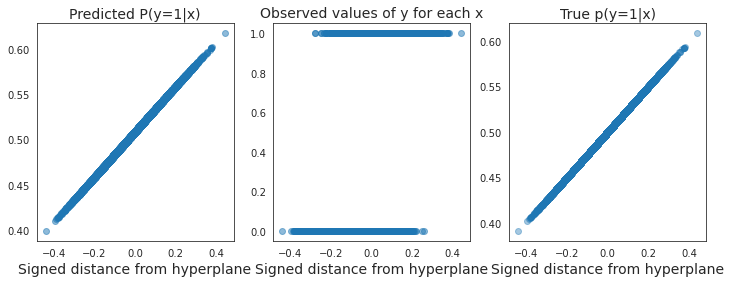

In [9]:
# Visualize predictions on training data
n_dims = g1_config['n_attributes']
y_pred = f1_model.model.predict_proba(x_train_norm[:,2:])[:,1]
ortho_normal = np.expand_dims(1*np.ones(n_attributes), 0)
features_train = np.dot(ortho_normal, x_train_norm[:,2:].T)
normalization = np.dot(ortho_normal, ortho_normal.T)[0][0]
features_train = features_train/normalization
y_true = (1/(1 + np.exp(-features_train*1)))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(features_train[0], y_pred, label='pred', alpha=.5)
axs[0].set_title("Predicted P(y=1|x)")
axs[0].set_xlabel("Signed distance from hyperplane")

axs[1].scatter(features_train[0], y_train, label='true', alpha=.5)
axs[1].set_title("Observed values of y for each x")
axs[1].set_xlabel("Signed distance from hyperplane")

axs[2].scatter(features_train[0], y_true, label='p(y)', alpha=.4)
axs[2].set_title("True p(y=1|x)")
axs[2].set_xlabel("Signed distance from hyperplane")

(1, 6000) (6000,)


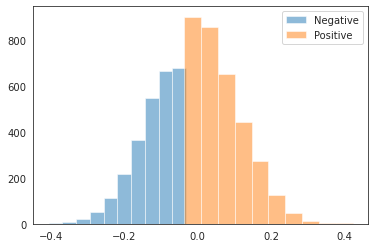

In [10]:
# Visualize predictions on test data 
y_pred = f1_model.predict_proba(x_test_norm)
ortho_normal = np.expand_dims(1*np.ones(n_attributes), 0)
features_test = np.dot(ortho_normal, x_test_norm[:,2:].T)
normalization = np.dot(ortho_normal, ortho_normal.T)[0][0]
features_test = features_test/normalization
binarized_y_pred = (y_pred > .5).astype(int)
print(features_test.shape, y_pred.shape)
plt.hist(features_test[0, binarized_y_pred == 0], alpha=.5, label='Negative')
plt.hist(features_test[0, binarized_y_pred == 1], alpha=.5, label='Positive')
plt.legend()

In [11]:
pred_rel_prior, pred_g1_prior, pred_g2_prior = eval_relative_prior(x_test, f1_model, 
                                                                   f2_model, g1_config['group1_idx'],
                                                                   g1_config['n_groups'])
true_g1_prior = y_test[g1_test_idxs].mean()
true_g2_prior = y_test[g2_test_idxs].mean()
print("Pred G1 Prior: ", pred_g1_prior, "Pred G2 Prior: ", pred_g2_prior)
print("True G1 Prior: ", true_g1_prior, "True G2 Prior: ", true_g2_prior)
print("True Relative Prior: ", true_g1_prior/true_g2_prior)
print("Pred Relative Prior: ", pred_g1_prior/pred_g2_prior)
print("Rel Error:", (pred_g1_prior/pred_g2_prior) / (true_g1_prior/true_g2_prior) )

Pred G1 Prior:  0.6624939573055214 Pred G2 Prior:  0.3443617593818164
True G1 Prior:  0.6575 True G2 Prior:  0.346
True Relative Prior:  1.9002890173410405
Pred Relative Prior:  1.9238313757450956
Rel Error: 1.0123888304301187


# Train our model

100%|██████████| 1000/1000 [00:05<00:00, 195.36it/s]


/local/divyas/invisible_conditions/relative_prevalence_benchmark/model_ckpts/c6b6d1596eb060792d78e7c552a02790model_final_1000


Text(0, 0.5, 'CE Loss')

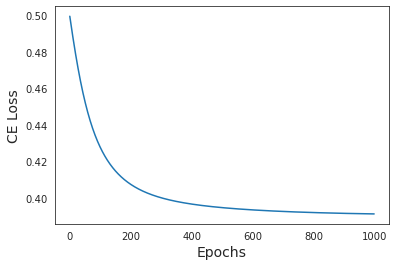

In [13]:
# Set regularization parameter
g1_config['estimator_type'] = 'logreg'
g1_config['optimizer'] = 'Adam'
g1_config['group_weights'] = (1, 1)
g1_config['n_epochs'] = 1000
g1_config['n_batches'] = 1

f_model, losses, info = train_relative_estimator(x_train, s_train, x_test, s_test, g1_config, save_model=True)
# pred_rel_prior, pred_g1_prior, pred_g2_prior = eval_relative_prior(x_test, f_model)
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("CE Loss")

In [14]:
print(info['auc'], info['auprc'])

0.7782456793236754 0.39190100689084195


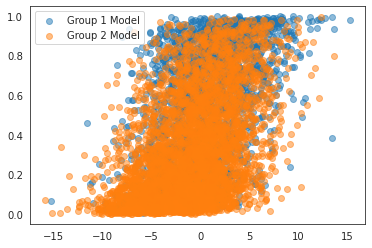

In [15]:
# Visual check to see if the same decision rule is learned for both group 1 & group 2
y1_test_pred = f_model.estimate_p_y(torch.Tensor(x_test[g1_test_idxs,2:]).cuda()).detach().cpu().numpy().squeeze()
y2_test_pred = f_model.estimate_p_y(torch.Tensor(x_test[g2_test_idxs,2:]).cuda()).detach().cpu().numpy().squeeze()
plt.scatter(x_test[g1_test_idxs,2], y1_test_pred,  alpha=.5, label='Group 1 Model')
plt.scatter(x_test[g2_test_idxs,2], y2_test_pred, alpha=.5, label='Group 2 Model')
plt.legend()

In [16]:
np.mean(y1_test_pred) + np.mean(y2_test_pred), np.mean(s1_train) + np.mean(s2_train)

(0.9298781, 0.43174999999999997)

In [17]:
# Looking at weights - based on generative model, weights are equal to one another in the true solution
f_model.p_y_coeffs.weight, f_model.p_y_coeffs.bias, f_model.get_c_g()

(Parameter containing:
 tensor([[0.1948, 0.1916, 0.1777, 0.1893, 0.1786]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.2339], device='cuda:0', requires_grad=True),
 tensor([[0.5290, 0.4434]], device='cuda:0', grad_fn=<SigmoidBackward>))

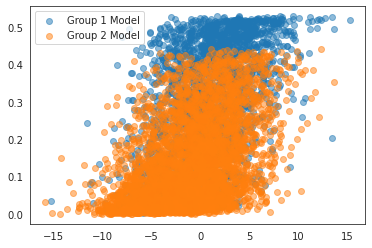

In [18]:
# Plot p(s|x)
s1_test_pred = f_model(torch.Tensor(x_test[g1_test_idxs]).cuda()).detach().cpu().numpy().squeeze()
s2_test_pred = f_model(torch.Tensor(x_test[g2_test_idxs]).cuda()).detach().cpu().numpy().squeeze()

plt.scatter(x_test[g1_test_idxs,2], s1_test_pred,  alpha=.5, label='Group 1 Model')
plt.scatter(x_test[g2_test_idxs,2],s2_test_pred, alpha=.5, label='Group 2 Model')
plt.legend()

In [19]:
true_g1_prior = y_test[g1_test_idxs].mean()
true_g2_prior = y_test[g2_test_idxs].mean()
print("Pred G1 Prior: ", pred_g1_prior, "Pred G2 Prior: ", pred_g2_prior)
print("True G1 Prior: ", true_g1_prior, "True G2 Prior: ", true_g2_prior)
print("True Relative Prior: ", true_g1_prior/true_g2_prior)
print("Pred Relative Prior: ", pred_rel_prior)

Pred G1 Prior:  0.6624939573055214 Pred G2 Prior:  0.3443617593818164
True G1 Prior:  0.6575 True G2 Prior:  0.346
True Relative Prior:  1.9002890173410405
Pred Relative Prior:  1.9238313757450956
